In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from deeper.deeper_utils import wrap_deeper
from explanation.deepmatcher_utils import wrapDm
from explanation.mojito2 import explainSamples,aggregateRankings
import pandas as pd
import deepmatcher as dm
from keras.models import load_model
from deeper.DeepER import init_embeddings_index,init_embeddings_model

Using TensorFlow backend.


## Prelimary operations

In [3]:
# Caricamento strutture dati e modelli ausiliari.
EMBEDDING_FILEPATH ='embeddings/glove.840B.300d.txt'
embeddings_index = init_embeddings_index(EMBEDDING_FILEPATH)
embeddings_model, tokenizer = init_embeddings_model(embeddings_index)

* Costruzione indice degli embeddings.....Fatto. 2196016 embeddings totali.
* Creazione del modello per il calcolo degli embeddings....
* Inizializzo il tokenizzatore.....Fatto: 1702926 parole totali.
* Preparazione della matrice di embedding.....Fatto. Dimensioni matrice embeddings: (1702927, 300)

°°° EMBEDDING MODEL °°°
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tupla_A (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Tupla_B (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Embedding_lookup (Embedding)    (None, None, 300)    510878100  

In [4]:
def getCorrectPredictions(dataset,model,predict_fn):
    predictions = predict_fn(dataset,model,['label','id'])
    tp_group = dataset[(predictions[:,1]>=0.5)& (dataset['label'] == 1)]
    tn_group = dataset[(predictions[:,0] >=0.5)& (dataset['label']==0)]
    correctPredictions = pd.concat([tp_group,tn_group])
    print("Len of correct predictions is {}".format(len(correctPredictions)))
    return correctPredictions

In [5]:
predict_fn_deeper = lambda data,model,ignore: wrap_deeper(data,'ltable_','rtable_',model,tokenizer,embeddings_model,
                                                  ignore_columns=ignore)

In [6]:
predict_fn_deepmatcher = lambda data,model,ignore: wrapDm(data,model,ignore_columns=ignore)

## Walmart-Amazon

In [23]:
augmented_test = pd.read_csv('datasets/walmart_amazon/augmented_test.csv')
walmart = pd.read_csv('datasets/walmart_amazon/walmart.csv',dtype=str)
amazon = pd.read_csv('datasets/walmart_amazon/amazon.csv',dtype=str)

In [16]:
walmart_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
walmart_deepmatcher.load_state('models/walmart_amazon_rnn.pth')
walmart_deeper = load_model('models/DeepER_best_model_100_walmart-amazon.h5')

In [28]:
correct_pred_deepmatcher = getCorrectPredictions(augmented_test,walmart_deepmatcher,predict_fn_deepmatcher)

Len of correct predictions is 820


In [29]:
correct_pred_deeper = getCorrectPredictions(augmented_test,walmart_deeper,predict_fn_deeper)

Len of correct predictions is 816


In [30]:
negrank,_,_ = explainSamples(correct_pred_deeper,[walmart,amazon],walmart_deeper,predict_fn_deeper,0,1)

100%|██████████| 521/521 [00:08<00:00, 63.38it/s]


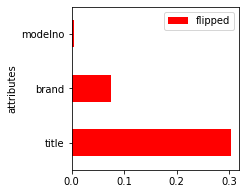

In [33]:
ax,negrank = aggregateRankings(negrank,positive=False,maxLenAttributes=1,lenTriangles=521)

In [34]:
negrank,_,_ = explainSamples(correct_pred_deepmatcher,[walmart,amazon],walmart_deepmatcher,
                             predict_fn_deepmatcher,0,1)

100%|██████████| 548/548 [03:13<00:00,  2.83it/s]


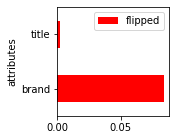

In [35]:
ax,negrank = aggregateRankings(negrank,positive=False,maxLenAttributes=1,lenTriangles=548)

In [37]:
posrank_deeper,_,_ = explainSamples(correct_pred_deeper,[walmart,amazon],walmart_deeper,predict_fn_deeper,
                             1,1)

100%|██████████| 521/521 [00:10<00:00, 48.86it/s]


In [38]:
posrank_deepmatcher,_,_ = explainSamples(correct_pred_deepmatcher,[walmart,amazon],walmart_deepmatcher,
                                         predict_fn_deepmatcher,1,1)

100%|██████████| 548/548 [03:10<00:00,  2.87it/s]


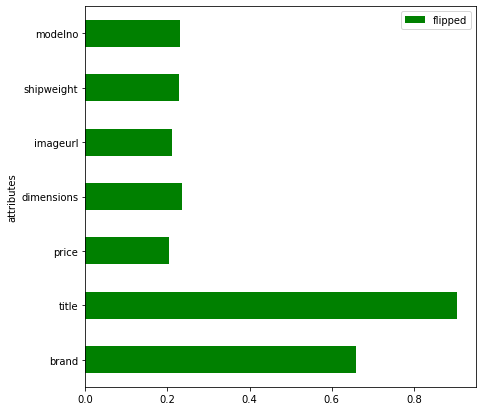

In [39]:
ax,posrank = aggregateRankings(posrank_deeper,positive=True,maxLenAttributes=1,lenTriangles=521)

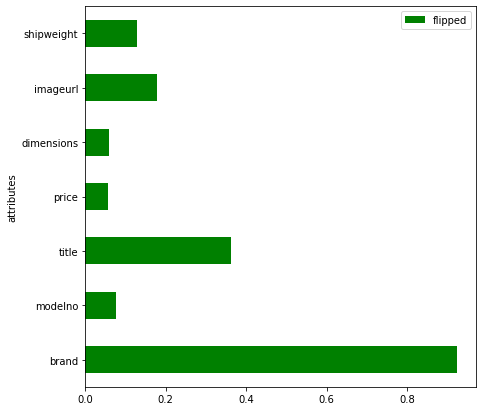

In [40]:
ax,posrank = aggregateRankings(posrank_deepmatcher,positive=True,maxLenAttributes=1,lenTriangles=548)

## Amazon-Google

In [41]:
augmented_test = pd.read_csv('datasets/Amazon-GoogleProducts/augmented_test.csv')
amazon = pd.read_csv('datasets/Amazon-GoogleProducts/Amazon.csv',dtype=str)
google = pd.read_csv('datasets/Amazon-GoogleProducts/Google.csv',dtype=str)

In [42]:
amzgoogle_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
amzgoogle_deepmatcher.load_state('models/amazon_google_rnn.pth')
amzgoogle_deeper = load_model('models/DeepER_best_model_100_amazon-google.h5')

In [43]:
correct_pred_deepmatcher = getCorrectPredictions(augmented_test,amzgoogle_deepmatcher,predict_fn_deepmatcher)
correct_pred_deeper = getCorrectPredictions(augmented_test,amzgoogle_deeper,predict_fn_deeper)

Len of correct predictions is 634
Len of correct predictions is 567


In [44]:
negrank_deeper,_,_ = explainSamples(correct_pred_deeper,[amazon,google],amzgoogle_deeper,predict_fn_deeper,0,1)

100%|██████████| 183/183 [00:11<00:00, 15.28it/s]


In [45]:
negrank_deepmatcher,_,_ = explainSamples(correct_pred_deepmatcher,[amazon,google],amzgoogle_deepmatcher
                                         ,predict_fn_deepmatcher,0,1)

100%|██████████| 303/303 [02:08<00:00,  2.36it/s]


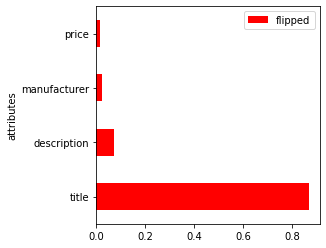

In [46]:
ax,negrank = aggregateRankings(negrank_deeper,positive=False,maxLenAttributes=1,lenTriangles=183)

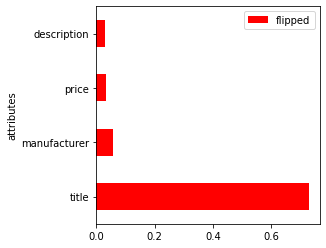

In [47]:
ax,negrank = aggregateRankings(negrank_deepmatcher,positive=False,maxLenAttributes=1,lenTriangles=303)

In [57]:
posrank_deeper,_,_ = explainSamples(correct_pred_deeper,[amazon,google],amzgoogle_deeper,predict_fn_deeper,1,1)



  0%|          | 0/183 [00:00<?, ?it/s]

  2%|▏         | 4/183 [00:00<00:05, 32.42it/s]

  3%|▎         | 6/183 [00:00<00:09, 18.81it/s]

  4%|▍         | 7/183 [00:00<00:18,  9.58it/s]

  4%|▍         | 8/183 [00:00<00:25,  6.74it/s]

  5%|▍         | 9/183 [00:01<00:28,  6.14it/s]

  5%|▌         | 10/183 [00:01<00:32,  5.38it/s]

  7%|▋         | 13/183 [00:01<00:24,  7.06it/s]

  8%|▊         | 15/183 [00:01<00:29,  5.65it/s]

  9%|▉         | 17/183 [00:01<00:23,  7.12it/s]

 11%|█         | 20/183 [00:02<00:19,  8.45it/s]

 12%|█▏        | 22/183 [00:02<00:17,  8.97it/s]

 14%|█▎        | 25/183 [00:02<00:13, 11.36it/s]

 16%|█▌        | 29/183 [00:02<00:13, 11.24it/s]

 17%|█▋        | 31/183 [00:03<00:18,  8.28it/s]

 19%|█▊        | 34/183 [00:03<00:17,  8.70it/s]

 20%|█▉        | 36/183 [00:03<00:15,  9.67it/s]

 22%|██▏       | 40/183 [00:03<00:13, 10.72it/s]

 23%|██▎       | 43/183 [00:04<00:12, 11.40it/s]

 25%|██▍       | 45/183 [00:04<00:18,  7.64it/s]

 26%|██▌    

In [58]:
posrank_deepmatcher,_,_ = explainSamples(correct_pred_deepmatcher,[amazon,google],amzgoogle_deepmatcher,
                                         predict_fn_deepmatcher,1,1)



  0%|          | 0/303 [00:00<?, ?it/s]

  0%|          | 1/303 [00:00<01:37,  3.11it/s]

  1%|          | 2/303 [00:00<01:34,  3.17it/s]

  1%|          | 3/303 [00:00<01:33,  3.22it/s]

  1%|▏         | 4/303 [00:01<01:31,  3.27it/s]

  2%|▏         | 5/303 [00:01<01:50,  2.71it/s]

  2%|▏         | 6/303 [00:02<01:57,  2.52it/s]

  2%|▏         | 7/303 [00:02<02:02,  2.41it/s]

  3%|▎         | 8/303 [00:03<02:10,  2.27it/s]

  3%|▎         | 9/303 [00:03<02:15,  2.16it/s]

  3%|▎         | 10/303 [00:04<02:21,  2.07it/s]

  4%|▎         | 11/303 [00:04<02:21,  2.07it/s]

  4%|▍         | 12/303 [00:05<02:56,  1.65it/s]

  4%|▍         | 13/303 [00:06<03:14,  1.49it/s]

  5%|▍         | 14/303 [00:07<03:20,  1.44it/s]

  5%|▍         | 15/303 [00:07<03:15,  1.47it/s]

  5%|▌         | 16/303 [00:08<03:11,  1.50it/s]

  6%|▌         | 17/303 [00:08<02:40,  1.78it/s]

  6%|▌         | 18/303 [00:09<02:21,  2.02it/s]

  6%|▋         | 19/303 [00:09<02:05,  2.27it/s]

  7%|▋         |

 95%|█████████▌| 288/303 [01:55<00:05,  2.78it/s]

 95%|█████████▌| 289/303 [01:55<00:04,  2.93it/s]

 96%|█████████▌| 290/303 [01:55<00:04,  3.01it/s]

 96%|█████████▌| 291/303 [01:56<00:04,  2.99it/s]

 96%|█████████▋| 292/303 [01:56<00:03,  3.04it/s]

 97%|█████████▋| 293/303 [01:57<00:03,  2.68it/s]

 97%|█████████▋| 294/303 [01:57<00:03,  2.85it/s]

 97%|█████████▋| 295/303 [01:57<00:02,  3.00it/s]

 98%|█████████▊| 296/303 [01:57<00:02,  3.12it/s]

 98%|█████████▊| 297/303 [01:58<00:01,  3.13it/s]

 98%|█████████▊| 298/303 [01:58<00:01,  3.16it/s]

 99%|█████████▊| 299/303 [01:58<00:01,  2.96it/s]

 99%|█████████▉| 300/303 [01:59<00:01,  2.90it/s]

 99%|█████████▉| 301/303 [01:59<00:00,  2.92it/s]

100%|█████████▉| 302/303 [02:00<00:00,  2.94it/s]

100%|██████████| 303/303 [02:00<00:00,  2.52it/s]


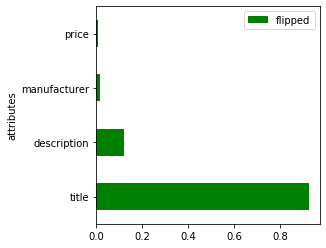

In [52]:
ax,posrank = aggregateRankings(posrank_deeper,positive=True,maxLenAttributes=1,lenTriangles=183)

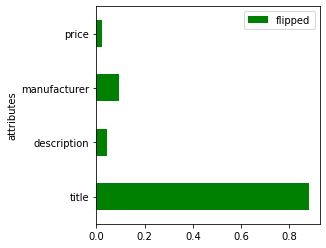

In [53]:
ax,posrank = aggregateRankings(posrank_deepmatcher,positive=True,maxLenAttributes=1,lenTriangles=303)

## DBLP-ACM

In [11]:
augmented_test = pd.read_csv('datasets/DBLP-ACM/augmented_test.csv')
dblp = pd.read_csv('datasets/DBLP-ACM/DBLP2.csv',dtype=str)
acm = pd.read_csv('datasets/DBLP-ACM/ACM.csv',dtype=str)

In [8]:
dblpacm_deeper = load_model('models/DeepER_best_model_100_dblp-acm.h5')
dblpacm_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
dblpacm_deepmatcher.load_state('models/dblp_acm_rnn.pth')

In [9]:
correct_deeper = getCorrectPredictions(augmented_test,dblpacm_deeper,predict_fn_deeper)
correct_deepmatcher = getCorrectPredictions(augmented_test,dblpacm_deepmatcher,predict_fn_deepmatcher)

Len of correct predictions is 1157
Len of correct predictions is 1182


In [12]:
negrank_deeper,_,_ = explainSamples(correct_deeper,[dblp,acm],dblpacm_deeper,predict_fn_deeper,
                                   0,1)

100%|██████████| 599/599 [00:06<00:00, 85.98it/s]


In [13]:
negrank_deepmatcher,_,_ = explainSamples(correct_deepmatcher,[dblp,acm],dblpacm_deepmatcher,predict_fn_deepmatcher,
                                        0,1)

100%|██████████| 629/629 [02:09<00:00,  4.86it/s]


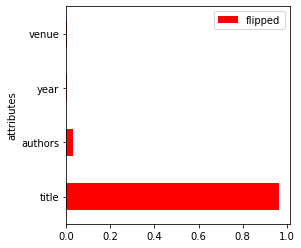

In [14]:
ax,negrank = aggregateRankings(negrank_deeper,positive=False,maxLenAttributes=1,lenTriangles=599)

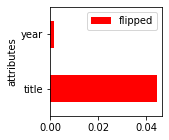

In [15]:
ax,negrank = aggregateRankings(negrank_deepmatcher,positive=False,maxLenAttributes=1,lenTriangles=629)

In [16]:
posrank_deeper,_,_ = explainSamples(correct_deeper,[dblp,acm],dblpacm_deeper,predict_fn_deeper,
                                   1,1)

100%|██████████| 599/599 [00:07<00:00, 81.38it/s]


In [17]:
posrank_deepmatcher,_,_ = explainSamples(correct_deepmatcher,[dblp,acm],dblpacm_deepmatcher,predict_fn_deepmatcher,
                                        1,1)

100%|██████████| 629/629 [01:54<00:00,  5.48it/s]


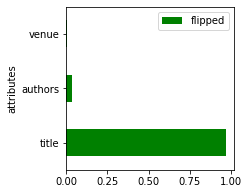

In [18]:
ax,posrank = aggregateRankings(posrank_deeper,positive=True,maxLenAttributes=1,lenTriangles=599)

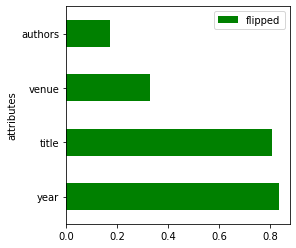

In [19]:
ax,posrank = aggregateRankings(posrank_deepmatcher,positive=True,maxLenAttributes=1,lenTriangles=629)

## Fodors-Zagats

In [20]:
augmented_test = pd.read_csv('datasets/fodors_zagats/augmented_test.csv')
fodors = pd.read_csv('datasets/fodors_zagats/fodors.csv',dtype=str)
zagats = pd.read_csv('datasets/fodors_zagats/zagats.csv',dtype=str)

In [21]:
fodors_deeper = load_model('models/DeepER_best_model_100_fodors-zagats.h5')
fodors_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
fodors_deepmatcher.load_state('models/fodors_zagats_rnn.pth')

In [22]:
correct_deeper = getCorrectPredictions(augmented_test,fodors_deeper,predict_fn_deeper)
correct_deepmatcher = getCorrectPredictions(augmented_test,fodors_deepmatcher,predict_fn_deepmatcher)

Len of correct predictions is 48
Len of correct predictions is 75


In [24]:
negrank_deeper,_,_ = explainSamples(correct_deeper,[fodors,zagats],fodors_deeper,predict_fn_deeper,
                                   0,1)

100%|██████████| 8/8 [00:00<00:00, 71.77it/s]


In [25]:
negrank_deepmatcher,_,_ = explainSamples(correct_deepmatcher,[fodors,zagats],fodors_deepmatcher,predict_fn_deepmatcher,
                                        0,1)

100%|██████████| 50/50 [00:05<00:00,  9.96it/s]


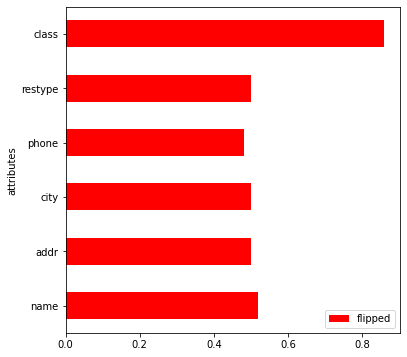

In [27]:
ax,negrank = aggregateRankings(negrank_deepmatcher,positive=False,maxLenAttributes=1,lenTriangles=50)

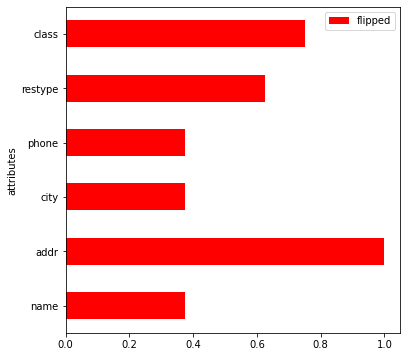

In [30]:
ax,negrank = aggregateRankings(negrank_deeper,positive=False,maxLenAttributes=1,lenTriangles=8)

In [31]:
posrank_deepmatcher,_,_ = explainSamples(correct_deepmatcher,[fodors,zagats],fodors_deepmatcher,predict_fn_deepmatcher,
                                        1,1)

100%|██████████| 50/50 [00:05<00:00,  9.90it/s]


In [33]:
posrank_deeper,_,_ = explainSamples(correct_deeper,[fodors,zagats],fodors_deeper,predict_fn_deeper,
                                   1,1)

100%|██████████| 8/8 [00:00<00:00, 65.88it/s]


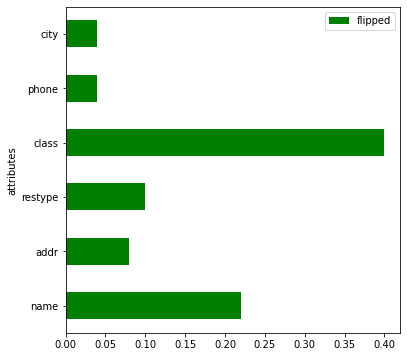

In [35]:
ax,posrank = aggregateRankings(posrank_deepmatcher,positive=True,maxLenAttributes=1,lenTriangles=50)

In [36]:
ax,posrank = aggregateRankings(posrank_deeper,positive=True,maxLenAttributes=1,lenTriangles=8)

ValueError: figure size must be positive finite not (0, 0)

## Itunes-Amazon

In [7]:
DATASET_DIR = 'datasets/itunes_amazon/'

In [12]:
augmented_test = pd.read_csv(DATASET_DIR+'augmented_test.csv')
itunes = pd.read_csv(DATASET_DIR+'itunes.csv',dtype=str)
amazon = pd.read_csv(DATASET_DIR+'amazon.csv',dtype=str)

In [9]:
itunes_deeper = load_model('models/DeepER_best_model_100_itunes-amazon.h5')
itunes_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
itunes_deepmatcher.load_state('models/itunes_amazon_rnn.pth')

In [10]:
correct_deeper = getCorrectPredictions(augmented_test,itunes_deeper,predict_fn_deeper)
correct_deepmatcher = getCorrectPredictions(augmented_test,itunes_deepmatcher,predict_fn_deepmatcher)

Len of correct predictions is 102
Len of correct predictions is 102


In [13]:
negrank_deeper,_,_ = explainSamples(correct_deeper,[itunes,amazon],itunes_deeper,predict_fn_deeper,
                                   0,1)

100%|██████████| 66/66 [00:01<00:00, 47.60it/s]


In [14]:
negrank_deepematcher,_,_ = explainSamples(correct_deepmatcher,[itunes,amazon],itunes_deepmatcher,
                                         predict_fn_deepmatcher,0,1)

100%|██████████| 76/76 [00:11<00:00,  6.48it/s]


In [15]:
posrank_deeper,_,_ = explainSamples(correct_deeper,[itunes,amazon],itunes_deeper,predict_fn_deeper,
                                   1,1)

100%|██████████| 66/66 [00:01<00:00, 46.79it/s]


In [16]:
posrank_deepmatcher,_,_ = explainSamples(correct_deepmatcher,[itunes,amazon],itunes_deepmatcher,predict_fn_deepmatcher,
                                        1,1)

100%|██████████| 76/76 [00:12<00:00,  5.95it/s]


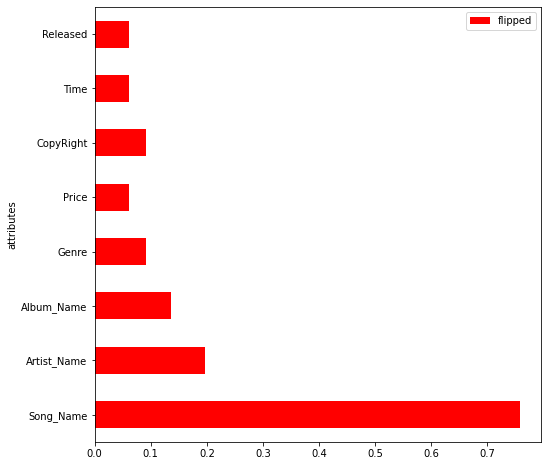

In [18]:
ax,negrank = aggregateRankings(negrank_deeper,positive=False,maxLenAttributes=1,lenTriangles=66)

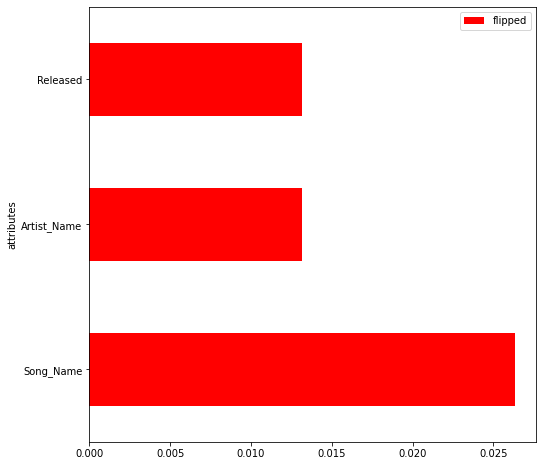

In [20]:
ax,negrank = aggregateRankings(negrank_deepematcher,positive=False,maxLenAttributes=1,lenTriangles=76)

In [ ]:
ax,posrank = aggregateRankings(posrank_deeper,positive=True,ma)